## 0. Imports

In [186]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Varios
# ==============================================================================
import sys
sys.path.append("src")
import src.support as sp
from scipy.sparse import csr_matrix
import pickle

In [187]:
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## 1. Lectura del conjunto de datos

In [188]:
import arff
import pandas as pd

with open('dataset_31_credit-g.arff', 'r') as file:
    data = arff.load(file)

df_origen = pd.DataFrame(data['data'], columns=[attr[0] for attr in data['attributes']])

df = df_origen.copy()

In [189]:
pd.set_option('display.max_columns', None)
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


In [190]:
df.shape

(1000, 21)

In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   object 
 1   duration                1000 non-null   float64
 2   credit_history          1000 non-null   object 
 3   purpose                 1000 non-null   object 
 4   credit_amount           1000 non-null   float64
 5   savings_status          1000 non-null   object 
 6   employment              1000 non-null   object 
 7   installment_commitment  1000 non-null   float64
 8   personal_status         1000 non-null   object 
 9   other_parties           1000 non-null   object 
 10  residence_since         1000 non-null   float64
 11  property_magnitude      1000 non-null   object 
 12  age                     1000 non-null   float64
 13  other_payment_plans     1000 non-null   object 
 14  housing                 1000 non-null   o

In [192]:
df.isnull().sum() / df.shape[0] * 100

checking_status           0.0
duration                  0.0
credit_history            0.0
purpose                   0.0
credit_amount             0.0
savings_status            0.0
employment                0.0
installment_commitment    0.0
personal_status           0.0
other_parties             0.0
residence_since           0.0
property_magnitude        0.0
age                       0.0
other_payment_plans       0.0
housing                   0.0
existing_credits          0.0
job                       0.0
num_dependents            0.0
own_telephone             0.0
foreign_worker            0.0
class                     0.0
dtype: float64

## 2. Exploración y preprocesado

### 2.1. Exploración

#### 2.1.1. Variable respuesta

In [193]:
df["class"].value_counts()

# No hace falta balancear los datos ya que hay una buena representación de la clase "bad"

class
good    700
bad     300
Name: count, dtype: int64

#### 2.1.1. Variables numéricas

In [194]:
df.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [195]:
df["installment_commitment"].value_counts()

installment_commitment
4.0    476
2.0    231
3.0    157
1.0    136
Name: count, dtype: int64

In [196]:
df["residence_since"].value_counts()

residence_since
4.0    413
2.0    308
3.0    149
1.0    130
Name: count, dtype: int64

In [197]:
df["existing_credits"].value_counts()

existing_credits
1.0    633
2.0    333
3.0     28
4.0      6
Name: count, dtype: int64

In [198]:
df["num_dependents"].value_counts()

num_dependents
1.0    845
2.0    155
Name: count, dtype: int64

In [199]:
# Transformamos las columnas a tipo string porque son variables categóricas realmente.

df["installment_commitment"] = df["installment_commitment"].astype("str")
df["residence_since"] = df["residence_since"].astype("str")
df["existing_credits"] = df["existing_credits"].astype("str")
df["num_dependents"] = df["num_dependents"].astype("str")

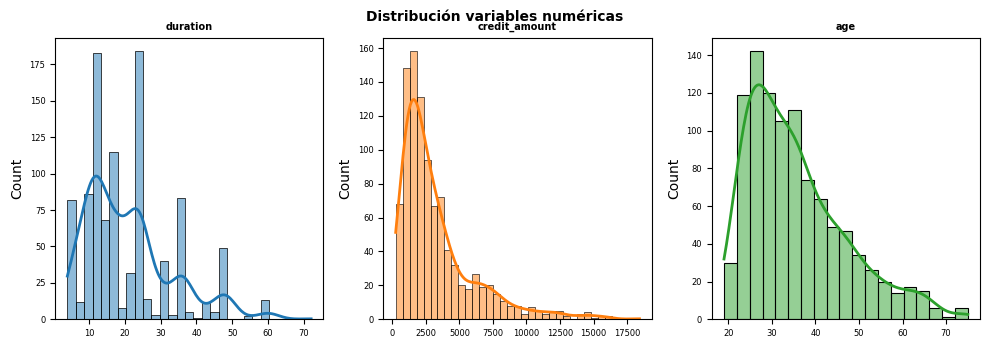

In [200]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))
axes = axes.flat
columnas_numeric = df.select_dtypes(include=['float64', 'int']).columns

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data     = df,
        x        = colum,
        stat     = "count",
        kde      = True,
        color    = (list(plt.rcParams['axes.prop_cycle']))[i]["color"],
        line_kws = {'linewidth': 2},
        alpha    = 0.5,
        ax       = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

# Duración: la mayoría de créditos duran 1 o 2 años (12, 24 meses).
# Credit_amount: las cantidades pedidas tienen un sesgo hacia la izquierda.
# Age: los créditos los pide la gente más joven.
# Como hay sesgo, vamos a ver si hay outliers con boxplots.
# Importante la estandarización para que las predicciones no den más peso a la variable credit_amount.
# Si uso Standard Scaler, lo que haremos es restar la media y dividir por la desviación típica. 
# Si uso Robust Scaler, mejoramos la estandarización en el caso de haber muchos outliers porque en vez de trabajar con la media 
# y la desviación típica trabaja con la mediana y con el rango intercuartílico.
# Con MinMaxScaler lo que hacemos es llevar todos los valores entre 0 y 1. Es parecido a Standard Scaler.

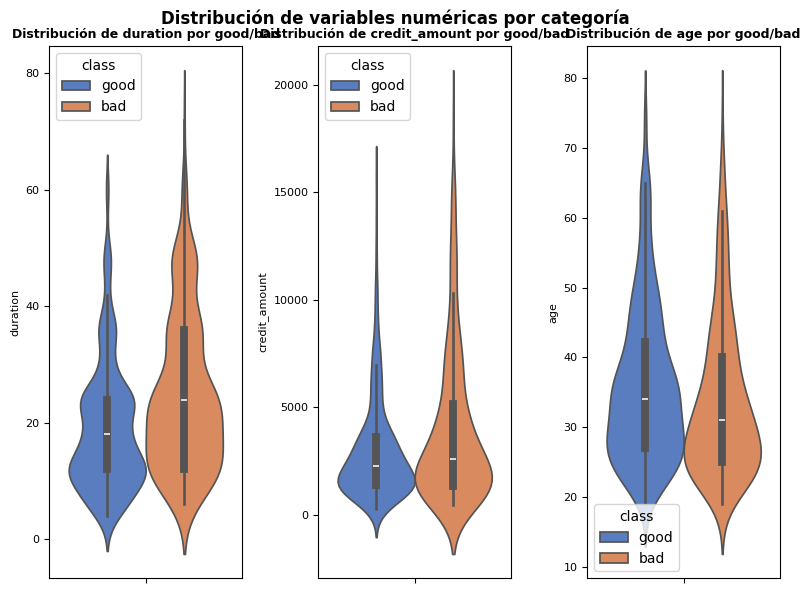

In [201]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 6))
axes = axes.flat
columnas_numeric = df.select_dtypes(include=['float64', 'int']).columns

for i, colum in enumerate(columnas_numeric):
    sns.violinplot(
        hue=df["class"],
        y=df[colum], 
        ax=axes[i], 
        palette="muted", 
        density_norm="width", 
        inner="box",
    )
    axes[i].set_title(f"Distribución de {colum} por good/bad", fontsize=9, fontweight="bold")
    axes[i].tick_params(labelsize=8)
    axes[i].set_xlabel("")
    axes[i].set_ylabel(colum, fontsize=8)

# Eliminar ejes vacíos si hay menos variables que subplots
for j in range(len(columnas_numeric), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.subplots_adjust(top=0.92)
fig.suptitle('Distribución de variables numéricas por categoría', fontsize=12, fontweight="bold")
plt.show();

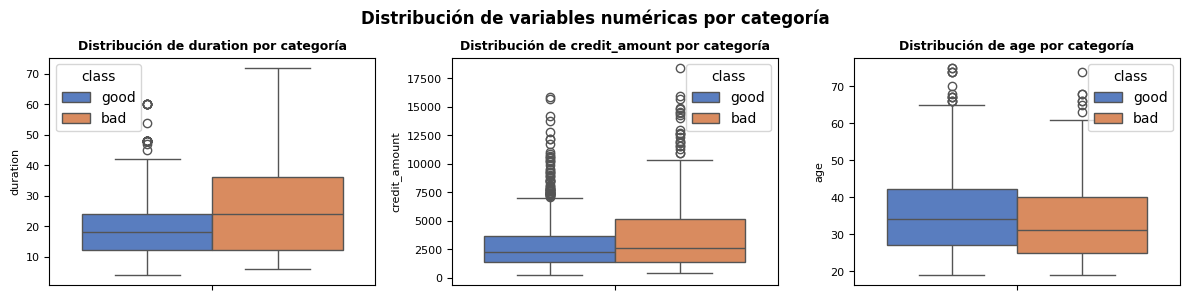

In [202]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
axes = axes.flat
columnas_numeric = df.select_dtypes(include=['float64', 'int']).columns

for i, colum in enumerate(columnas_numeric):
    sns.boxplot(
        hue=df['class'], 
        y=df[colum], 
        ax=axes[i], 
        palette="muted"
    )
    axes[i].set_title(f"Distribución de {colum} por categoría", fontsize=9, fontweight="bold")
    axes[i].tick_params(labelsize=8)
    axes[i].set_xlabel("")
    axes[i].set_ylabel(colum, fontsize=8)

# Eliminar ejes vacíos si hay menos variables que subplots
for j in range(len(columnas_numeric), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.subplots_adjust(top=0.92)
fig.suptitle('Distribución de variables numéricas por categoría', fontsize=12, fontweight="bold")
plt.show()


In [203]:
# Probaremos a quitar outliers.

df_sin_outliers = df[(df["credit_amount"] <= 6000) & (df["age"] <= 70) & (df["duration"] <= 45)]

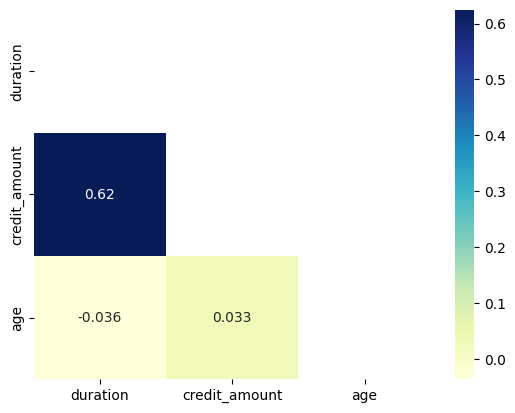

In [204]:
mask = np.triu(np.ones_like(df.select_dtypes(include=np.number).corr(), dtype = bool))
sns.heatmap(df.select_dtypes(include=np.number).corr(), 
           cmap = "YlGnBu", 
            mask = mask,
           annot = True);

# La duración del crédito y la cantidad de crédito están relacionadas en un 0.62, tiene sentido.

#### 2.1.2. Variables categóricas

In [205]:
df.describe(include="object").T

,count,unique,top,freq
checking_status,1000,4,no checking,394
credit_history,1000,5,existing paid,530
purpose,1000,10,radio/tv,280
savings_status,1000,5,<100,603
employment,1000,5,1<=X<4,339
installment_commitment,1000,4,4.0,476
personal_status,1000,4,male single,548
other_parties,1000,3,none,907
residence_since,1000,4,4.0,413
property_magnitude,1000,4,car,332


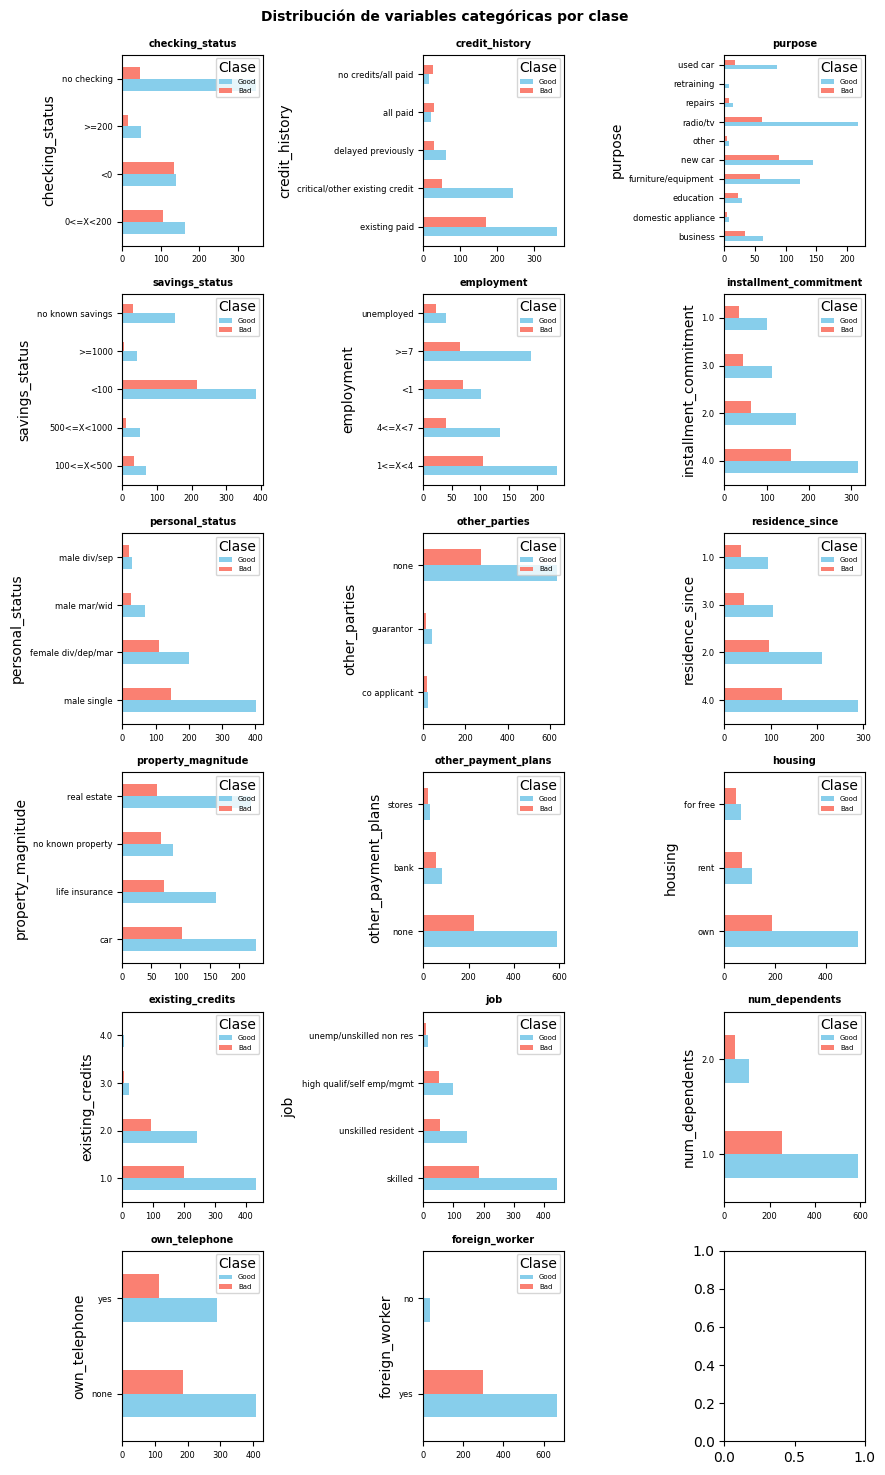

In [206]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(9, 15))
axes = axes.flat
columnas_object = df.select_dtypes(include=['object']).columns.drop("class")

for i, colum in enumerate(columnas_object):

    good_counts = df[df["class"] == "good"][colum].value_counts()
    bad_counts = df[df["class"] == "bad"][colum].value_counts()

    # Combinar los valores en un DataFrame
    counts_df = pd.DataFrame({
        "Good": good_counts,
        "Bad": bad_counts
    }).fillna(0)

    # Graficar
    counts_df.plot(kind="barh", ax=axes[i], color=["skyblue", "salmon"])

    # Personalización del gráfico
    axes[i].set_title(colum, fontsize=7, fontweight="bold")
    axes[i].tick_params(labelsize=6)
    axes[i].set_xlabel("")
    axes[i].legend(title="Clase", fontsize=5, loc="upper right")

# Ajustar diseño general
fig.tight_layout()
plt.subplots_adjust(top=0.95)
fig.suptitle('Distribución de variables categóricas por clase',
             fontsize=10, fontweight="bold")
plt.show()


In [207]:
# Al hacer la validación cruzada es posible que algunas particiones no tengan ninguna observación de dicha clase.
# 1. Purpose: crear una categoría Other para los valores más pequeños.
# 2. Other Parties: Reorganizar entre Yes / No
# 3. Other Payment Plans: Podemos reorganizar la clasifación entre Yes / No.
# 4. Existing_credits: Reorganizar en 1 y >=2.
# 5. Foreign_worker: trabajar únicamente con personas extranjeras.

In [208]:
"""sp.reorganizar(df, "purpose", "other", 5)
sp.reorganizar(df, "other_parties", "Yes", 7)
sp.reorganizar(df, "other_payment_plans", "Yes", 15)
sp.reorganizar(df, "existing_credits", ">=2", 50)"""

'sp.reorganizar(df, "purpose", "other", 5)\nsp.reorganizar(df, "other_parties", "Yes", 7)\nsp.reorganizar(df, "other_payment_plans", "Yes", 15)\nsp.reorganizar(df, "existing_credits", ">=2", 50)'

In [209]:
df.purpose.value_counts()

purpose
radio/tv               280
new car                234
furniture/equipment    181
used car               103
business                97
education               50
repairs                 22
domestic appliance      12
other                   12
retraining               9
Name: count, dtype: int64

In [210]:
df.other_parties.value_counts()

other_parties
none            907
guarantor        52
co applicant     41
Name: count, dtype: int64

In [211]:
df.other_payment_plans.value_counts()

other_payment_plans
none      814
bank      139
stores     47
Name: count, dtype: int64

In [212]:
df.existing_credits.value_counts()

existing_credits
1.0    633
2.0    333
3.0     28
4.0      6
Name: count, dtype: int64

In [213]:
df = df[df["foreign_worker"] == "yes"]

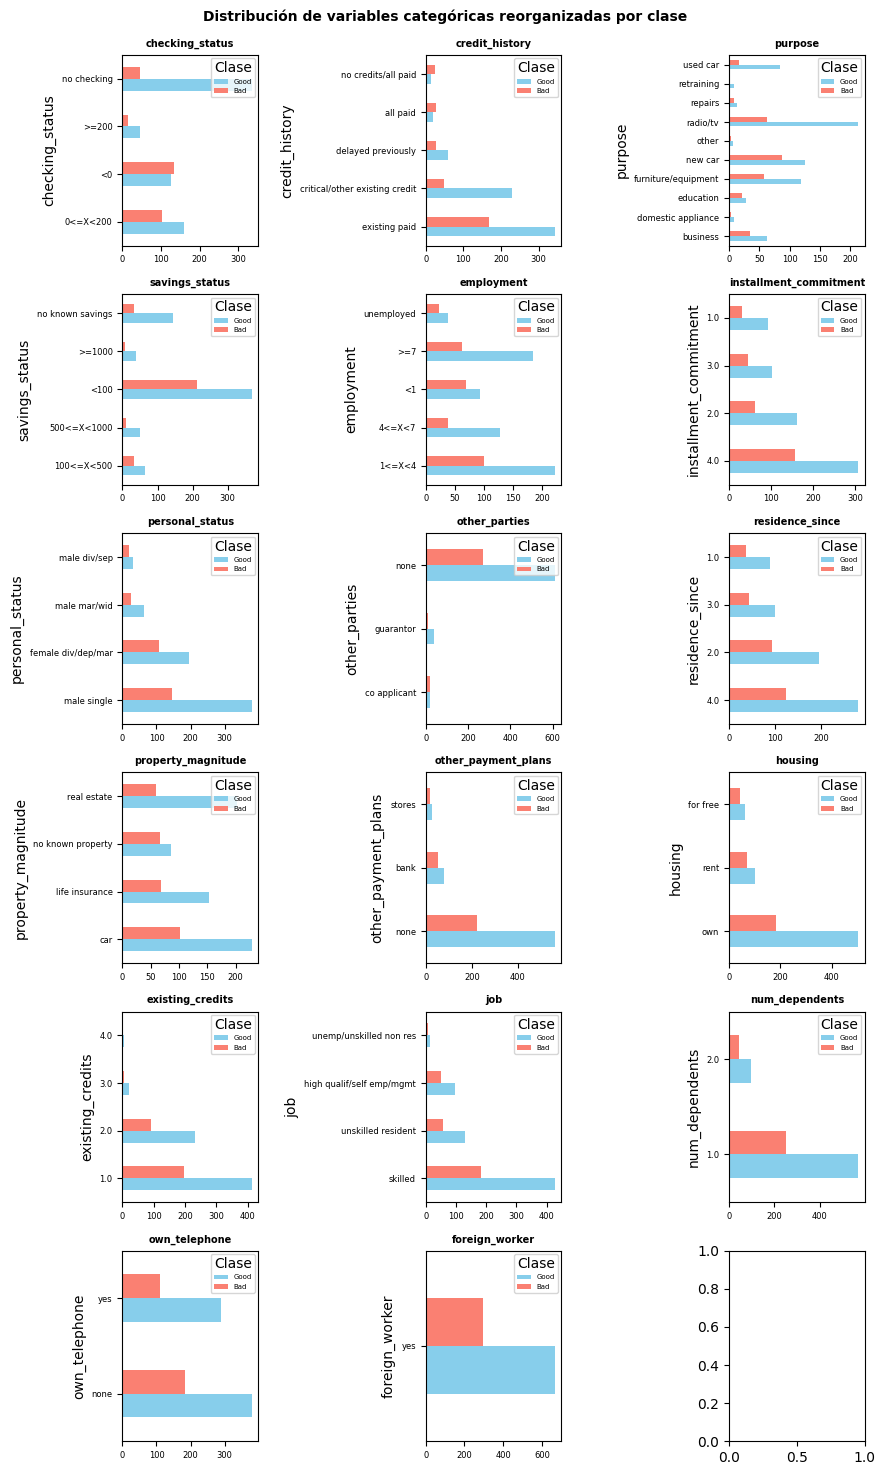

In [214]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(9, 15))
axes = axes.flat
columnas_object = df.select_dtypes(include=['object']).columns.drop("class")

for i, colum in enumerate(columnas_object):

    good_counts = df[df["class"] == "good"][colum].value_counts()
    bad_counts = df[df["class"] == "bad"][colum].value_counts()

    # Combinar los valores en un DataFrame
    counts_df = pd.DataFrame({
        "Good": good_counts,
        "Bad": bad_counts
    }).fillna(0)

    # Graficar
    counts_df.plot(kind="barh", ax=axes[i], color=["skyblue", "salmon"])

    # Personalización del gráfico
    axes[i].set_title(colum, fontsize=7, fontweight="bold")
    axes[i].tick_params(labelsize=6)
    axes[i].set_xlabel("")
    axes[i].legend(title="Clase", fontsize=5, loc="upper right")

# Ajustar diseño general
fig.tight_layout()
plt.subplots_adjust(top=0.95)
fig.suptitle('Distribución de variables categóricas reorganizadas por clase',
             fontsize=10, fontweight="bold")
plt.show()

In [215]:
# df.drop(labels="foreign_worker", axis=1, inplace=True)

## 3. División del conjunto de datos

In [216]:
train_set, val_set, test_set = sp.train_val_test_split(df)
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 577
Longitud del Validation Set: 193
Longitud del Test Set: 193


In [217]:
X_train, y_train = sp.remove_labels(train_set, "class")
X_val, y_val = sp.remove_labels(val_set, "class")
X_test, y_test = sp.remove_labels(test_set, "class")

## 4. Preparación del conjunto de datos

In [218]:
num_attribs = list(X_train.select_dtypes(exclude=['object']))
cat_attribs = list(X_train.select_dtypes(include=['object']))

In [219]:
num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("rbst_scaler", RobustScaler())
])

In [220]:
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.encoders = {}

    def fit(self, X, y=None):
        for col in self.columns:
            le = LabelEncoder()
            le.fit(X[col])
            self.encoders[col] = le
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = self.encoders[col].transform(X[col])
        return X_copy


In [221]:
cat_pipeline = Pipeline([("oh", OneHotEncoder())])

In [222]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [223]:
X_train_prep = full_pipeline.fit_transform(X_train)
sparse_matrix = csr_matrix(X_train_prep)
X_train_prep = pd.DataFrame.sparse.from_spmatrix(
    sparse_matrix, 
    columns=list(pd.get_dummies(X_train)), 
    index=X_train.index
)

In [224]:
le = LabelEncoder()
y_train_prep = le.fit_transform(y_train)

## 5. Entrenamiento del algoritmo

In [276]:
log_reg = LogisticRegression(C=1000)

In [277]:
log_reg.fit(X_train_prep, y_train)

LogisticRegression(C=1000)

## 6. Predicciones

In [278]:
X_val_prep = full_pipeline.transform(X_val)
sparse_matrix_prep = csr_matrix(X_val_prep)
X_val_prep = pd.DataFrame.sparse.from_spmatrix(sparse_matrix_prep, columns=list(pd.get_dummies(X_train)), index=X_val.index)

In [279]:
y_val_pred = log_reg.predict(X_val_prep)
y_val_pred_prep = le.transform(y_val_pred)

## 7. Evaluación de los resultados 

In [296]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(log_reg, X_train_prep, y_train_prep, cv=2, scoring="f1")
scores

array([0.80288462, 0.82725061])

In [281]:
log_reg.get_params()

{'C': 1000,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [282]:
y_val_prep = le.transform(y_val)

In [283]:
bias = y_val_pred_prep.mean() - y_val_prep.mean()
bias

0.041450777202072464

In [284]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val_prep, y_val_pred_prep)

array([[ 30,  29],
       [ 21, 113]], dtype=int64)

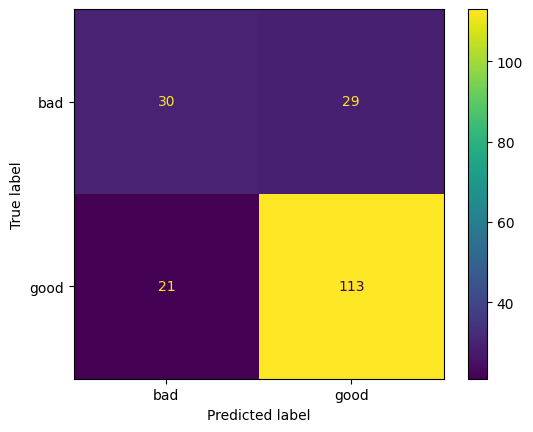

In [285]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(log_reg, X_val_prep, y_val, values_format='d')

In [286]:
print("Accuray:", metrics.accuracy_score(y_val, y_val_pred))
print("Precision (bad):", metrics.precision_score(y_val, y_val_pred, pos_label="bad"))
print("Recall:", metrics.recall_score(y_val, y_val_pred, pos_label='bad'))
print("F1 score:", metrics.f1_score(y_val, y_val_pred, pos_label='bad'))

Accuray: 0.7409326424870466
Precision (bad): 0.5882352941176471
Recall: 0.5084745762711864
F1 score: 0.5454545454545454


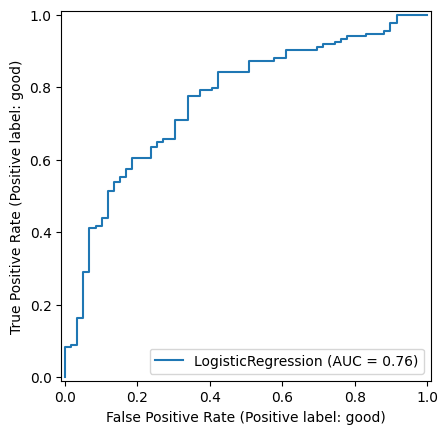

In [288]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(log_reg, X_val_prep, y_val)

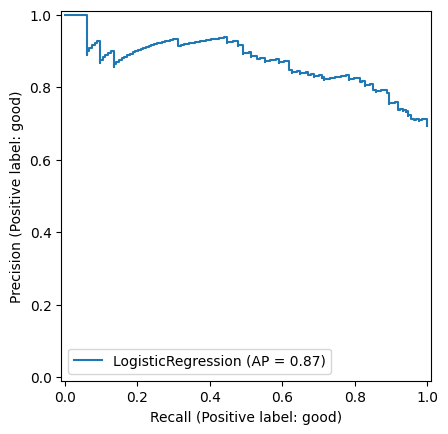

In [236]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(log_reg, X_val_prep, y_val)

## 11. Otros modelos

### 11.1. Decision Tree

In [237]:
clf = DecisionTreeClassifier()

In [238]:
param_grid = {"max_depth": [1, 10, 100, 500, 1000],
              "min_samples_split": [2, 3, 5]}

grid_search = GridSearchCV(clf, param_grid, cv=5,
                           scoring='f1')

grid_search.fit(X_train_prep, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 10, 100, 500, 1000],
                         'min_samples_split': [2, 3, 5]},
             scoring='f1')

In [239]:
best_tree = grid_search.best_estimator_
grid_search.best_params_

{'max_depth': 1, 'min_samples_split': 2}

In [240]:
best_tree.fit(X_train_prep, LabelEncoder().fit_transform(y_train))

DecisionTreeClassifier(max_depth=1)

In [241]:
y_val_tree = best_tree.predict(X_val_prep)

In [242]:
print("F1 score:", metrics.f1_score(LabelEncoder().fit_transform(y_val), y_val_tree, pos_label=1))

F1 score: 0.8195718654434251


#### 11.1.2. Decision Tree - Conjunto de pruebas

In [243]:
X_test_prep = full_pipeline.transform(X_test)
sparse_matrix_prep = csr_matrix(X_test_prep)
X_test_prep = pd.DataFrame.sparse.from_spmatrix(sparse_matrix_prep, columns=list(pd.get_dummies(X_train)), index=X_test.index)

In [244]:
y_test_pred = best_tree.predict(X_test_prep)

In [245]:
print("F1 score:", metrics.f1_score(LabelEncoder().fit_transform(y_test), y_test_pred, pos_label=1))

F1 score: 0.8195718654434251


### 11.2. Random Forests

In [246]:
clf_rnd = RandomForestClassifier(n_estimators=10000, random_state=42, n_jobs=-1)
clf_rnd.fit(X_train_prep, y_train_prep)

RandomForestClassifier(n_estimators=10000, n_jobs=-1, random_state=42)

In [247]:
y_train_pred_forest = clf_rnd.predict(X_train_prep)
y_val_pred_forest   = clf_rnd.predict(X_val_prep)
y_val_pred_forest

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1])

In [248]:
print("F1 score:", metrics.f1_score(LabelEncoder().fit_transform(y_val), y_val_pred_forest, pos_label=1))

F1 score: 0.8384879725085911


### 11.3. Suppor Vector Machines (SVM)